# Import & Setting

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.display.float_format = '{:.15f}'.format


# Parameter Setting

In [2]:
CFG = {
    'EPOCHS':60,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':64,
    'SEED':41
}

# Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 다중 GPU 환경
    torch.backends.cudnn.deterministic = True  # 결정론적 알고리즘 강제
    torch.backends.cudnn.benchmark = False     # 알고리즘 선택 비활성화

seed_everything(CFG['SEED']) # Seed 고정

# Load Data

In [4]:
file_path = '/Users/toad/Documents/ToyProject/Heat_Treatment_PdM/'

In [5]:
train = pd.read_csv(file_path+'Data/train_normal.csv').drop(columns='Unnamed: 0')
valid = pd.read_csv(file_path+'Data/valid_normal.csv').drop(columns='Unnamed: 0')
test = pd.read_csv(file_path+'Data/test_normal.csv').drop(columns='Unnamed: 0')
anomaly = pd.read_csv(file_path+'Data/anomaly_data.csv').drop(columns='Unnamed: 0')

In [6]:
print(f'Normal Data')
print(f'- Train Data : {len(train)}')
print(f'- Valid Data : {len(valid)}')
print(f'- Test Data : {len(test)}')
print(f'--------------------------------')
print(f'Anomaly Data : {len(anomaly)}')

Normal Data
- Train Data : 2020534
- Valid Data : 288648
- Test Data : 288648
--------------------------------
Anomaly Data : 2717


In [7]:
display(train.head())
print(f'Columns : {train.columns.values}')

,CP(제어) OP,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,소입4존 OP,...,소입로 CP 모니터 값,소입로 온도 2 Zone,솔트 1존 OP,솔트 2존 OP,솔트 슬러지 제거,솔트 컨베이어 온도 1 Zone,솔트 컨베이어 온도 2 Zone,솔트조 온도 1 Zone,outliers_cnt,anomaly
0,27.5181,69.4988,28.0363,100.366,100.353,69.2698,84.3415,57.7779,50.8080,70.3781,...,1.149530e-10,860.286,70.7822,59.7691,325.772,288.802,285.324,328.856,1,0
1,27.5181,69.5777,28.2541,100.366,100.353,69.2698,89.9508,58.0981,49.5654,70.6791,...,1.150360e-10,860.272,72.1144,59.8864,325.711,288.728,285.311,328.783,1,0
2,28.8494,69.6464,30.5821,100.366,100.291,69.2085,85.0744,58.0155,51.0691,70.6326,...,1.149300e-10,860.272,72.1144,59.8864,325.833,288.789,285.372,328.783,2,0
3,28.8494,69.8280,28.3900,100.428,100.353,69.2698,84.9387,57.9397,49.4850,70.6453,...,1.150360e-10,860.272,71.0169,59.8864,325.833,288.728,285.372,328.844,1,0
4,28.8494,72.1245,26.3033,100.366,100.353,69.2085,84.9810,57.9252,49.4771,70.6567,...,1.150360e-10,860.272,71.0169,59.8864,325.833,288.728,285.372,328.844,1,0


Columns : ['CP(제어) OP' '건조 1존 OP' '건조 2존 OP' '건조로 온도 1 Zone' '건조로 온도 2 Zone' '세정기'
 '소입1존 OP' '소입2존 OP' '소입3존 OP' '소입4존 OP' '소입로 CP 값' '소입로 CP 모니터 값'
 '소입로 온도 2 Zone' '솔트 1존 OP' '솔트 2존 OP' '솔트 슬러지 제거' '솔트 컨베이어 온도 1 Zone'
 '솔트 컨베이어 온도 2 Zone' '솔트조 온도 1 Zone' 'outliers_cnt' 'anomaly']


# Data Processing

#### Delete outliers count & anomaly feature

In [8]:
print(f'''train cols : {len(train.columns)}
valid cols : {len(valid.columns)}
test cols : {len(test.columns)}
anomaly cols : {len(anomaly.columns)}''')
train.drop(columns=['outliers_cnt', 'anomaly'], inplace=True)
valid.drop(columns=['outliers_cnt', 'anomaly'], inplace=True)
test.drop(columns=['outliers_cnt'], inplace=True)
anomaly.drop(columns=['outliers_cnt'], inplace=True)
print(f'''train cols : {len(train.columns)}
valid cols : {len(valid.columns)}
test cols : {len(test.columns)}
anomaly cols : {len(anomaly.columns)}''')

train cols : 21
valid cols : 21
test cols : 21
anomaly cols : 21
train cols : 19
valid cols : 19
test cols : 20
anomaly cols : 20


#### Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# For normal Test data
train_scaled = scaler.fit_transform(train)
valid_scaled = scaler.transform(valid)
# test_scaled = scaler.transform(test)
# anomaly_scaled = scaler.transform(anomaly)

# Dataset


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [11]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

        
    def __getitem__(self, index): 
        return self.data[index]
        
    def __len__(self): 
        return self.data.shape[0]

In [12]:
train_dataset = CustomDataset(train_scaled)
valid_dataset = CustomDataset(valid_scaled)
# test_dataset = CustomDataset(test_scaled)
# anomaly_dataset = CustomDataset(anomaly_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
# anomaly_dataloader = DataLoader(anomaly_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

# Modeling

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(19,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        self.Decoder = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,19),
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

# Train

In [14]:
def loss_plot(train_loss, valid_loss):
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Valid Loss')
    plt.yscale("log")  # Y축 로그 스케일
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()

In [15]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, valid_loader, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.device = device
        # Loss function
        self.criterion = nn.MSELoss().to(self.device)
        # Loss array
        self.train_mean_list = []
        self.valid_mean_list = []
    
    def fit(self,):
        self.model.to(self.device)
        best_loss = 100000000
        
        for epoch in range(CFG['EPOCHS']):
            self.model.train()
            train_loss = []
            
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x) # after autoencoder
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            valid_loss = self.validation(self.model)
            
            mean_train_loss = np.mean(train_loss)
            mean_valid_loss = np.mean(valid_loss)
            self.train_mean_list.append(mean_train_loss)
            self.valid_mean_list.append(mean_valid_loss)
            
            print(f'Epoch : [{epoch}] Train Loss : [{mean_train_loss:.20f}] Valid Loss : [{mean_valid_loss:.20f}]')
            
            if mean_valid_loss < best_loss:
                best_loss = mean_valid_loss
                torch.save(self.model.state_dict(), f'{epoch}_best_model.pth')
            # else:
            #     print(f'Early Stopping in Epoch : [{epoch}] Best Loss : [{best_loss}]')
            #     loss_plot(train_mean_list, valid_mean_list) # visualize loss
            #     break
        loss_plot(self.train_mean_list, self.valid_mean_list) # visualize loss
    
    def validation(self, model):
        model.eval()
        valid_loss = []
        with torch.no_grad():
            for x in iter(self.valid_loader):
                x = x.float().to(self.device)
                _x = model(x)
                loss = self.criterion(x, _x)
                valid_loss.append(loss.item())
        return valid_loss


In [16]:
# model = AutoEncoder()
# optimizer = optim.Adam(params=model.parameters(), lr=CFG['LEARNING_RATE'])

# trainer = Trainer(model, optimizer, train_dataloader, valid_dataloader, device)
# trainer.fit()

Kaggle P100 Training Result 
- Best Model 
    - Epoch : [51]  
    - Train Loss : [0.00000356411259314551]  
    - Valid Loss : [0.00000229669710111774]
- Loss Plot
    
    <img src="/Users/toad/Documents/ToyProject/Heat_Treatment_PdM/Epoch60_Loss.png" alt="이미지 설명" width="500" height="400">

# Inference

In [18]:
# Validation Function
def validation(model, valid_loader, criterion):
        valid_loss = []
        with torch.no_grad():
            for x in iter(valid_loader):
                x = x.float().to(device)
                _x = model(x)
                loss = criterion(x, _x)
                valid_loss.append(loss.item())
        return valid_loss

In [19]:
model = AutoEncoder()
model.load_state_dict(torch.load(file_path+'/Code/best_model.pth', map_location=torch.device('cpu')))
model.to(device)
model.eval()

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=19, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
  )
  (Decoder): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=19, bias=True)
    (5): ReLU()
  )
)

In [ ]:
# Check Best Model Correctly Loaded
valid_loss = validation(model, valid_dataloader, nn.MSELoss().to(device))
print(f'Valid Loss : {np.mean(valid_loss):.20f}')

Valid Loss : 0.00000229669310084562


In [71]:
cols = test.columns
test_scaled = scaler.transform(test.iloc[:,:-1])
test_dataset = CustomDataset(test_scaled)
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)


In [94]:
len(test)

288648

In [385]:
def predict(model, data_loader, criterion, title):
    loss_list = []
    with torch.no_grad():
        for x in iter(data_loader):
                x = x.float().to(device)
                _x = model(x)
                x = x.cpu().numpy()
                _x = _x.cpu().numpy()
                loss = np.abs(x - _x).mean(axis=1)
                loss_list.extend(loss.tolist())
    print(f'Mean Loss : {np.mean(loss_list):.20f}')
    return np.array(loss_list)

In [443]:
def predict_plot(loss, title):
    plt.figure(figsize=(12, 6))  # 가로 12, 세로 6
    sns.histplot(loss, bins=200, kde=True, kde_kws={'bw_adjust': 1.5})
    # plt.yscale("log")  # Y축 로그 스케일
    # plt.xlim(0, 0.01) 
    plt.ticklabel_format(useOffset=False, style='plain')  # 일반 숫자 형식
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [386]:
train_loss = predict(model, train_dataloader, nn.MSELoss(reduction='none'), 'Train Data Distribution')
valid_loss = predict(model, valid_dataloader, nn.MSELoss(reduction='none'), 'Valid Data Distribution')

Mean Loss : 0.00076027527217529406
Mean Loss : 0.00084067291275487265


In [387]:
train_loss.shape, valid_loss.shape

((2020534,), (288648,))

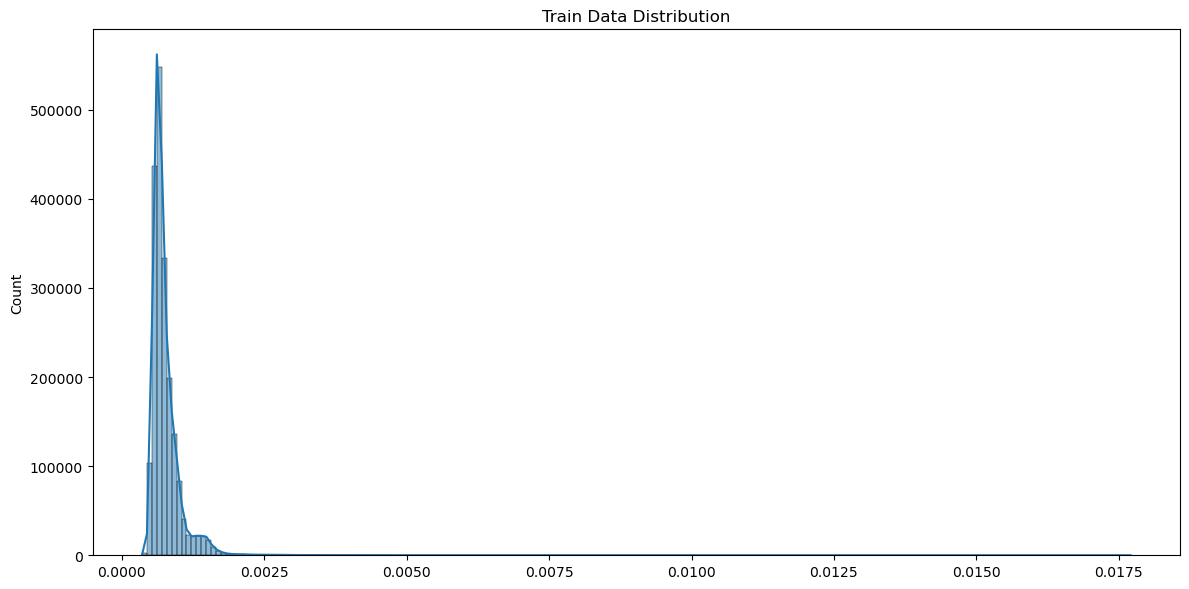

In [444]:
predict_plot(train_loss, 'Train Data Distribution')

In [455]:
len(train_loss[train_loss > 0.01]) / len(train_loss) * 100

0.0020291665470613214

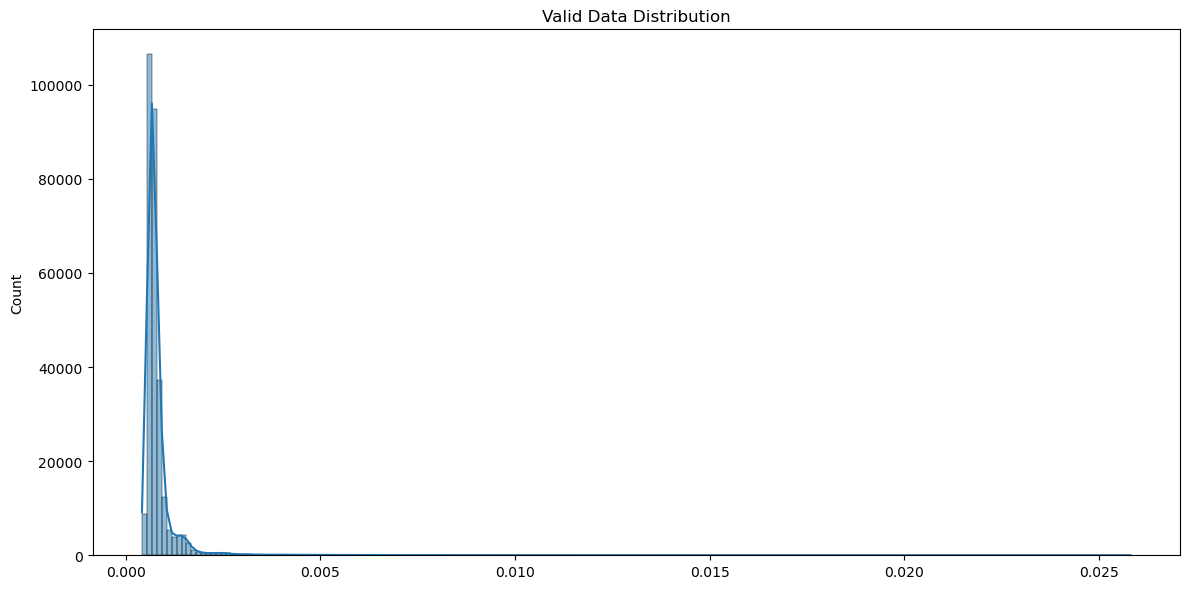

In [445]:
predict_plot(valid_loss, 'Valid Data Distribution')

In [454]:
len(valid_loss[valid_loss > 0.01])/len(valid_loss)*100

0.13164823591363875

In [394]:
test_loss = predict(model, test_dataloader, nn.MSELoss(reduction='none'), 'Train Data Distribution')

Mean Loss : 0.00082743132883099911


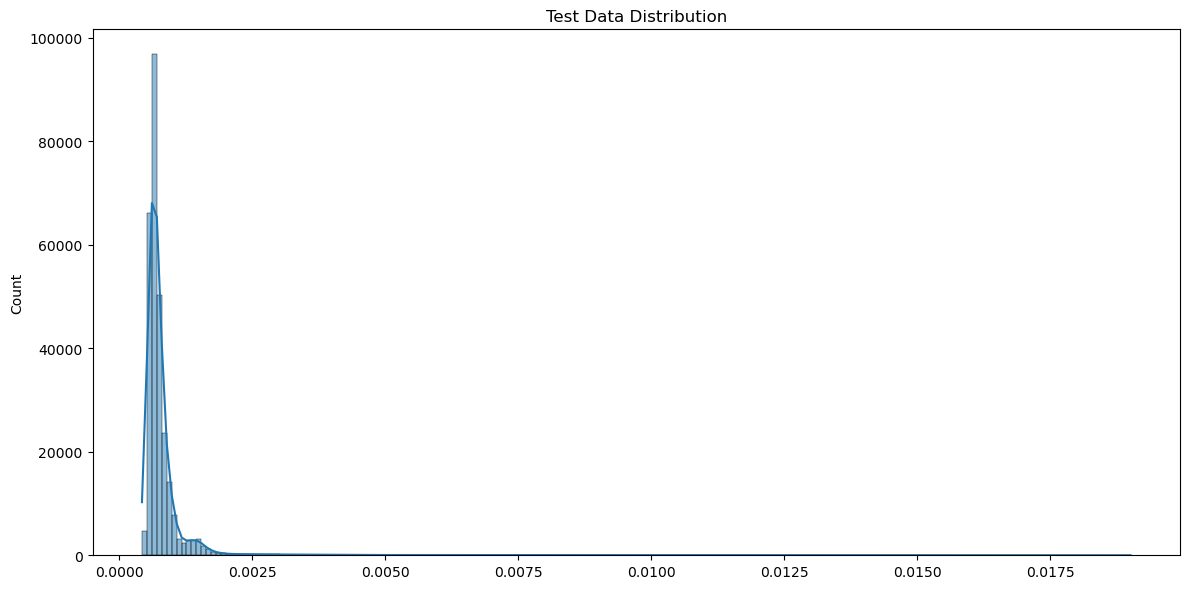

In [446]:
predict_plot(test_loss, 'Test Data Distribution')

In [456]:
len(test_loss[test_loss > 0.01])/len(test_loss)*100

0.1427344031484715

In [398]:
anomaly_scaled = scaler.transform(anomaly.iloc[:,:-1])
anomaly_dataset = CustomDataset(anomaly_scaled)
anomaly_dataloader = DataLoader(anomaly_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [399]:
anomaly_loss = predict(model, anomaly_dataloader, nn.MSELoss(reduction='none'), 'Anomaly Data Distribution')

Mean Loss : 0.21874125400403179875


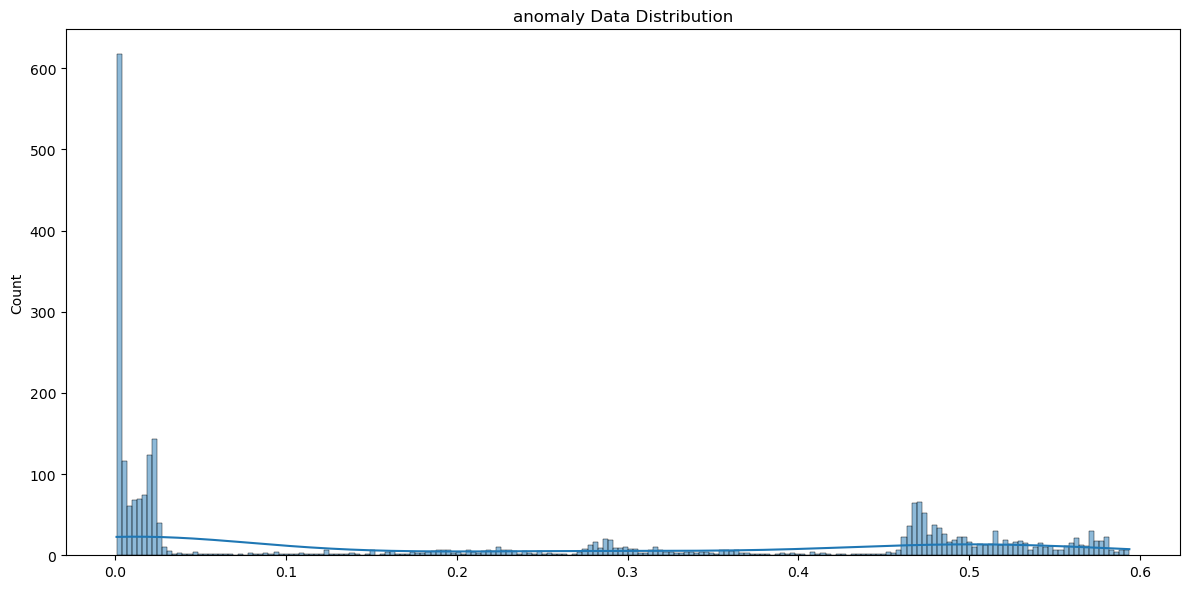

In [447]:
predict_plot(anomaly_loss, 'anomaly Data Distribution')

In [457]:
len(anomaly_loss[anomaly_loss > 0.01])/len(anomaly_loss)*100

70.44534412955466

In [462]:
thr = 0.001

test_df = pd.DataFrame(test_loss, columns=['loss'])
test_df['answer'] = 0
test_df['predict'] = (test_df.loss > thr).astype(int)

anomaly_df = pd.DataFrame(anomaly_loss, columns=['loss'])
anomaly_df['answer'] = 1
anomaly_df['predict'] = (anomaly_df.loss > thr).astype(int)

result_df = pd.concat([test_df, anomaly_df], axis=0)
result_df.reset_index(drop=True, inplace=True)
print(len(test_df), len(anomaly_df), len(test_df)+len(anomaly_df))
result_df


288648 2717 291365


,loss,answer,predict
0,0.000670801673550,0,0
1,0.000694911752362,0,0
2,0.000678613025229,0,0
3,0.000677340896800,0,0
4,0.000662073493004,0,0
...,...,...,...
291360,0.012710069306195,1,1
291361,0.010172890499234,1,1
291362,0.011568796820939,1,1
291363,0.006705311592668,1,1


<Axes: >

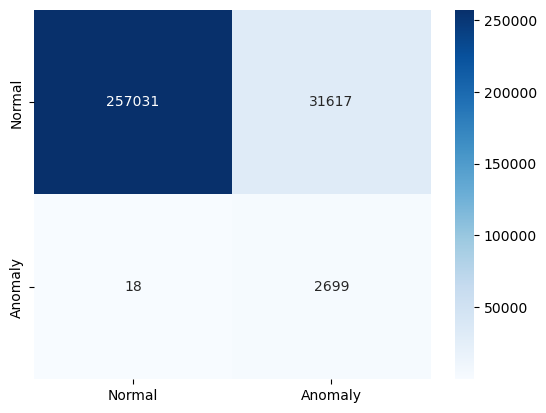

In [463]:
cm = confusion_matrix(result_df.answer, result_df.predict)
class_names = ['Normal', 'Anomaly']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)


In [464]:
f1_score(result_df.answer, result_df.predict)

0.145761888045797

In [465]:
print(classification_report(result_df.answer, result_df.predict, target_names=class_names))

              precision    recall  f1-score   support

      Normal       1.00      0.89      0.94    288648
     Anomaly       0.08      0.99      0.15      2717

    accuracy                           0.89    291365
   macro avg       0.54      0.94      0.54    291365
weighted avg       0.99      0.89      0.93    291365

